#### This notebook calculate performance of stock picks from the model 

In [36]:
def get_trading_date_n(date, idx_close, n, verbose=False):
  """
  Retrieves the trading date n days away from the input date, if it exists in the closing price index.

  Args:
      date (datetime): The starting date.
      idx_close (dict or Series): Date index of close prices.
      n (int): Number of days to move (positive for future, negative for past).
      verbose (bool, optional): Print debug information. Defaults to False.

  Returns:
      datetime or None: The trading date n days away from the input date, or None if not found.
  """

  # Check if the input date is present in the closing price index.
  if date in idx_close:
    # Calculate the index of the date n days away from the input date.
    idx_date_n = idx_close.get_loc(date) + n

    # Check if the calculated index is within the bounds of the closing price index.
    if 0 <= idx_date_n <= len(idx_close) - 1:
      # Retrieve the date n days away.
      date_n = idx_close[idx_date_n]

      if verbose:
        print(f"Retrieving date {n} days away: {date_n}")
    else:
      date_n = None
      if verbose:
        print(f"Date {n} days away is out of bounds.")
  else:
    date_n = None
    if verbose:
      print(f"Input date {date} not found in idx_close.")

  return date_n


In [37]:
def any_not_in_list(list1, list2):
  """
  Determines if any items in list1 are not present in list2.

  Args:
    list1: The first list of items.
    list2: The second list of items.

  Returns:
    True if any item in list1 is not found in list2, False otherwise.
  """

  # Create sets from the lists for efficient difference calculation.
  set1 = set(list1)
  set2 = set(list2)

  # Check for items in list1 that are not in list2 by using set difference.
  # If the difference is not empty, there are items in list1 not in list2.
  return bool(set1 - set2)

In [38]:
def is_date_in_close(date, df_close):
  """
  Determines if a given date is present in a DataFrame's index, considering only the date portion (YYYY-MM-DD).

  Args:
    date (str): The date to check in the format YYYY-MM-DD.
    df_close (pandas.DataFrame): A DataFrame containing a date index.

  Returns:
    str or None: The input date if found in the index, otherwise None.
  """

  # Format the index to YYYY-MM-DD for comparison, ensuring consistent string format.
  formatted_idx_close = df_close.index.strftime('%Y-%m-%d')

  # Check if the input date is present in the formatted index.
  if date in formatted_idx_close:
    # If found, return the date to confirm its presence.
    return date
  else:
    # If not found, return None to indicate its absence.
    return None

In [39]:
import numpy as np  # Import necessary libraries at the beginning
from ast import literal_eval

def calc_portf_shares(df_close, date, str_symbols, portf_target):
  """
  Calculates the number of shares to buy for each symbol in a portfolio to meet a target investment value.

  Args:
    df_close (pandas.DataFrame): DataFrame with closing prices, indexed by date and symbols.
    date (str): The date for which to calculate shares.
    str_symbols (str): String representation of a list of symbols to include in the portfolio.
    portf_target (float): The total target investment value for the portfolio.

  Returns:
    numpy.ndarray: An array containing the number of shares to buy for each symbol.
  """

  # 1. Convert string representation of symbols to a list
  l_syms = literal_eval(str_symbols)

  # 2. Retrieve closing prices for the specified symbols on the given date
  ar_price = df_close.loc[date][l_syms].values

  # 3. Calculate the target investment amount per symbol
  amt_per_sym = portf_target / len(l_syms)  # Calculate directly using len(l_syms)

  # 4. Calculate the number of shares to buy for each symbol, rounding down to whole shares
  ar_shares = np.floor(amt_per_sym / ar_price)

  return ar_shares

In [40]:
import numpy as np  # Import at the beginning for better organization
from ast import literal_eval

def calc_portf_value(df_close, date, str_symbols, ar_shares, verbose=False):
  """
  Calculates the total value of a portfolio of stocks for a given date.

  Args:
    df_close (pandas.DataFrame): DataFrame containing closing prices, indexed by date and symbols.
    date (str): The date for which to calculate the portfolio value.
    str_symbols (str): String representation of a list of symbols in the portfolio.
    ar_shares (numpy.ndarray): Array containing the number of shares held for each symbol.
    verbose (bool, optional): If True, prints details of the calculation. Defaults to False.

  Returns:
    tuple: A tuple containing the date, symbols, closing prices, shares, individual symbol values, and total portfolio value.
  """

  # 1. Convert string representation of symbols to a list
  l_syms = literal_eval(str_symbols)

  # 2. Retrieve closing prices for the specified symbols on the given date
  ar_price = df_close.loc[date][l_syms].values

  # 3. Calculate the dollar value invested in each symbol
  ar_value = ar_price * ar_shares

  # 4. Calculate the total portfolio value
  portf_value = sum(ar_value)  # Directly calculate the total value

  # 5. Print details if verbose is True
  if verbose:
    print(f"Portfolio value details:\n"
          f"- Date: {date}\n"
          f"- Symbols: {l_syms}\n"
          f"- Closing prices: {ar_price}\n"
          f"- Shares: {ar_shares}\n"
          f"- Individual symbol values: {ar_value}\n"
          f"- Total portfolio value: {portf_value}")

  # 6. Return the calculated values
  return date, l_syms, ar_price, ar_shares, ar_value, portf_value

In [41]:
def calc_portf_value_date_buy(idx_date, str_symbols, df_close, portf_target, n, verbose=False):
  """
  Calculates portfolio values for multiple dates and symbol combinations, handling potential data gaps.

  Args:
    idx_date (list): List of dates (str) to evaluate portfolios.
    str_symbols (list): List of symbol lists (str) to evaluate for each date.
    df_close (pandas.DataFrame): DataFrame with closing prices, indexed by date and symbols.
    portf_target (float): Target portfolio value for allocation.
    n (int): Number of trading days to offset execution from the lookback date.
    verbose (bool, optional): If True, prints details. Defaults to False.

  Returns:
    tuple: Tuple containing lists of buy dates, shares, and portfolio values for both the selected symbols and SPY.
  """

  from ast import literal_eval

  # Extract trading dates and symbols from the DataFrame
  idx_close = df_close.index.strftime('%Y-%m-%d')  # Trading dates in format YYYY-MM-DD
  symbols_df_close = df_close.columns  # Symbols in df_close

  # Initialize lists to store results
  date_exec = []  # Buy date of portfolio
  shares_syms = []  # Lists of shares of each symbol bought on each date
  value_portf = []  # List of portfolio values on each date
  shares_SPY = []  # List of shares of SPY bought on each date
  value_SPY = []  # List of values of SPY shares on each date

  # Iterate through pairs of dates and symbol lists
  for date, syms in zip(idx_date, str_symbols):

    # Determine the execution date based on the lookback date and the offset n
    next_date_n = get_trading_date_n(date, idx_close, n, verbose=False)
    close_date_n = is_date_in_close(next_date_n, df_close)

    # Print information for debugging
    print(f'++++++++++++++')
    print(f'date: {date}')
    print(f'n (days increment): {n}')         
    print(f'next_date_n: {next_date_n}')
    print(f'close_date_n: {close_date_n}')
    print(f'syms: {syms}')
    print(f'++++++++++++++')    

    #TODO ??? l_syms overwrite l_syms ???     
    # Convert string representation of symbols back to a list
    l_syms = literal_eval(syms)
    # print(f'syms: {syms}, l_syms: {l_syms}')
    #TODO ??? l_syms overwrite l_syms ???         

    # Check if any symbols are not present in the DataFrame
    sym_not_in_df_close = any_not_in_list(l_syms, symbols_df_close)

    if close_date_n is None or sym_not_in_df_close:
      # Handle missing data:
      print(f'l_syms: {l_syms}')  
      ## print(f'sym_not_in_df_close: {sym_not_in_df_close}')  
      print(f'l_syms are in df_close: {not sym_not_in_df_close}')        

      p_date = None
      p_ar_shares = None
      p_portf_value = None  # Set to None when data are not available
      SPY_shares = None
      SPY_value = None  # Set to None when data are not available

      if verbose:
        print(f"No data for close_date_n {close_date_n}, pick's portf value = None")
        print(f'No data for close_date_n {close_date_n}, SPY portf value =    None')

    else:
      # Calculate portfolio values when data is available:
      p_ar_shares = calc_portf_shares(df_close, close_date_n, syms, portf_target)
      p_date, _l_syms, _ar_price, _ar_shares, _ar_value, p_portf_value = calc_portf_value(df_close, close_date_n, syms, p_ar_shares, verbose)

      syms = str(['SPY'])
      SPY_shares = calc_portf_shares(df_close, close_date_n, syms, portf_target)
      _date, l_syms, _ar_price, _ar_shares, _ar_value, SPY_value = calc_portf_value(df_close, close_date_n, syms, SPY_shares, verbose)

      if verbose:
        print(f"close_date_n pick's portf value = {p_portf_value}")
        print(f'close_date_n SPY portf value =    {SPY_value}')

    date_exec.append(p_date)
    shares_syms.append(p_ar_shares)
    value_portf.append(p_portf_value)
    shares_SPY.append(SPY_shares)
    value_SPY.append(SPY_value)

    print('='*20, '\n')

  return date_exec, shares_syms, value_portf, shares_SPY, value_SPY

In [42]:
def calc_portf_value_date_n(idx_date, str_symbols, df_close, my_portf_shares, my_SPY_shares, n, verbose=False):
  """
  Calculates portfolio values for multiple dates and symbol combinations, taking pre-determined shares as input.

  Args:
    idx_date (list): List of dates (str) to evaluate portfolios.
    str_symbols (list): List of symbol lists (str) to evaluate for each date.
    df_close (pandas.DataFrame): DataFrame with closing prices, indexed by date and symbols.
    my_portf_shares (list): List of lists of shares for each symbol combination.
    my_SPY_shares (list): List of shares of SPY to evaluate for each date.
    n (int): Number of trading days to offset execution from the lookback date.
    verbose (bool, optional): If True, prints details. Defaults to False.

  Returns:
    tuple: Tuple containing lists of buy dates, shares, and portfolio values for both the selected symbols and SPY.
  """

  # Extract trading dates from the DataFrame
  idx_close = df_close.index.strftime('%Y-%m-%d')  # Trading dates in format YYYY-MM-DD

  # Initialize lists to store results
  date_exec = []  # Buy date of portfolio
  shares_syms = []  # Lists of shares of each symbol bought on each date
  value_portf = []  # List of portfolio values on each date
  shares_SPY = []  # List of shares of SPY bought on each date
  value_SPY = []  # List of values of SPY shares on each date

  # Iterate through pairs of dates, symbol lists, and shares
  for date, symbols, portf_shares, SPY_shares in zip(idx_date, str_symbols, my_portf_shares, my_SPY_shares):

    # Determine the execution date based on the lookback date and the offset n
    next_date_n = get_trading_date_n(date, idx_close, n, verbose=False)
    close_date_n = is_date_in_close(next_date_n, df_close)

    # Print information for debugging
    print(f'++++++++++++++')
    print(f'date: {date}')
    print(f'n (days increment): {n}')        
    print(f'next_date_n: {next_date_n}')
    print(f'close_date_n: {close_date_n}')
    print(f'symbols: {symbols}')
    print(f'++++++++++++++')   


    if close_date_n is None or portf_shares is None:
      # Handle missing data or missing shares:
      p_date_exec = None
      p_ar_shares = None
      p_value_portf = None  # Set to None when data or shares are unavailable
      SPY_ar_shares = None
      SPY_value_portf = None  # Set to None when data or shares are unavailable

      if verbose:
        print(f"No data for close_date_n {close_date_n}, pick's portf value = None")

    else:
      # Calculate portfolio values when data and shares are available:
      p_date_exec, _p_ar_syms, _p_ar_price, p_ar_shares, _p_ar_value, p_value_portf = calc_portf_value(df_close, close_date_n, symbols, portf_shares, verbose)

      SPY = str(['SPY'])  # Calculate SPY portfolio value separately
      _SPY_date_exec, _SPY_ar_syms, _SPY_ar_price, SPY_ar_shares, _SPY_ar_value, SPY_value_portf = calc_portf_value(df_close, close_date_n, SPY, SPY_shares, verbose)

      if verbose:
        print(f"next_date_n pick's portf value = {p_value_portf}")
        print(f'next_date_n SPY portf value =    {SPY_value_portf}')

    # Append results to lists
    date_exec.append(p_date_exec)
    shares_syms.append(p_ar_shares)
    value_portf.append(p_value_portf)
    shares_SPY.append(SPY_ar_shares)
    value_SPY.append(SPY_value_portf)

    print('='*20, '\n')

  return date_exec, shares_syms, value_portf, shares_SPY, value_SPY

In [43]:
import datetime

def calculate_date_n_days_back(input_date, n_days_back):
  """
  Calculates the date n days back from a given input date.

  Args:
    input_date (datetime.date): The input date.
    n_days_back (int): The number of days back from the input date.

  Returns:
    str: The date n days back from the input date, formatted as 'yyyy-mm-dd'.
  """

  previous_date = input_date - datetime.timedelta(days=n_days_back)
  previous_date_str = previous_date.strftime("%Y-%m-%d")

  return previous_date_str


# if __name__ == "__main__":
#   # Example usage
#   input_date = date.today()  # Replace with your desired date
#   n_days_back = 365*2
#   previous_date_str = calculate_date_n_days_back(input_date, n_days_back)
#   print(f"{input_date} - {n_days_back} days ago: {previous_date_str}")


In [44]:
import pandas as pd  # Explicitly import pandas for clarity

def sort_df_columns(df: pd.DataFrame) -> pd.DataFrame:
  """Sorts a DataFrame in descending order (most recent date first) by specified columns and reset index.

  Args:
      df: The DataFrame to be sorted.

  Returns:
      The sorted DataFrame.
  """

  # Define the sorting columns and order explicitly
  sorting_columns = ['date', 'days_lookback', 'syms_freq', 'symbols']
  ascending = False  # Descending order for all columns

  # Perform the sorting in a single step with clear variable names
  sorted_df = df.sort_values(by=sorting_columns, ascending=ascending).reset_index(drop=True)

  return sorted_df

In [45]:
def find_first_non_nan_in_column(df, column_name):
  """
  Finds the index of the first non-NaN value in a specific column of a DataFrame.

  Args:
      df (pd.DataFrame): The DataFrame to search.
      column_name (str): The name of the column to check for non-NaN values.

  Returns:
      int: The index of the first non-NaN value in the specified column,
       or -1 if no non-NaN values are found.
  """

  for idx, row in df.iterrows():
    # Check if all values in the current row are non-NaN (using vectorized operation)
    if not pd.isna(row[column_name]):
      return idx
  return -1

In [46]:
# Import libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array manipulation
import matplotlib.pyplot as plt  # For plotting
import matplotlib.dates as mdates  # For handling dates in plots
from datetime import date, timedelta  # For working with dates
from myUtils import pickle_load, pickle_dump  # For loading and saving data

# Set pandas display options
pd.set_option('display.max_rows', 100)  # Display up to 100 rows
pd.set_option('display.max_columns', 30)  # Display up to 30 columns
pd.set_option('display.max_colwidth', 30)  # Limit column width to 30 characters
pd.set_option('display.width', 900)  # Set overall display width to 900 characters

# Define file paths
path_dir = "C:/Users/ping/MyDrive/stocks/yfinance/"  # Base directory for stock data
path_data_dump = path_dir + "VSCode_dump/"  # Subdirectory for pickled data

# Define file names
fp_df_model_top_picks = 'df_model_top_picks'  # Model's top stock picks
fp_df_close_clean = 'df_close_clean'  # Historic closing prices
fp_df_model_perf = 'df_model_perf'  # Model picks' performance

# Set verbose mode
verbose = True  # Print information during execution if True

# Number of rows to check for missing data
check_n_rows = 200 

In [47]:
"""
Loads pre-processed datasets from pickled files.
"""

# Load the DataFrame containing historical closing prices:
df_close = pickle_load(path_data_dump, fp_df_close_clean)  # Load from the specified pickle file

# Load the DataFrame containing top stock picks from the model:
df_model_picks = pickle_load(path_data_dump, fp_df_model_top_picks)  # Load from the specified pickle file

In [48]:
"""
Extracts and prints information about the date range and length of the df_model_picks DataFrame.
"""

# Extract dates from the DataFrame and sort them chronologically:
dates_sorted = sorted(df_model_picks.date.tolist())  # Create a list of dates and sort them

# Extract the first and last dates to determine the date range:
date_start_model_picks = dates_sorted[0]  # Get the earliest date
date_end_model_picks = dates_sorted[-1]  # Get the latest date

# Print the date range and the number of rows in the DataFrame:
print(f'date_start_model_picks: {date_start_model_picks}')
print(f'date_end_model_picks: {date_end_model_picks}')
print(f'len(df_model_picks): {len(df_model_picks)}')  # Print the length (number of rows)

date_start_model_picks: 2018-07-06
date_end_model_picks: 2024-03-07
len(df_model_picks): 1533


In [49]:
"""
Filters the df_close DataFrame to match the date range of df_model_picks and extracts information.
"""

# Create a boolean mask to filter rows within the desired date range:
mask = (df_close.index >= date_start_model_picks) & (df_close.index <= date_end_model_picks)  # Select rows between the start and end dates

# Apply the mask to filter the DataFrame:
df_close = df_close.loc[mask]  # Keep only rows that meet the date criteria

# Extract trading dates as formatted strings:
idx_close = df_close.index.strftime('%Y-%m-%d')  # Get trading dates in YYYY-MM-DD format

# Extract symbols present in the filtered DataFrame:
symbols_df_close = df_close.columns  # Get a list of symbols in the DataFrame

# Display the filtered DataFrame to verify its contents:
print(f'df_close:\n{df_close}')  # Print the DataFrame to view the filtered data

df_close:
                     A         AA        AAL         AAP        AAPL         AB        ABBV        ABR         ABT       ACGL       ACHC       ACIW        ACLS       ACRS        ADBE  ...         XYL       YELP         YUM       YUMC         YY         ZBH        ZBRA         ZD         ZG       ZION          ZS        ZTO         ZTS       ZUMZ        ZWS
Date                                                                                                                                                                                    ...                                                                                                                                                                           
2018-07-06   59.826283  45.975018  37.283417  125.891396   44.732914  17.900511   74.443977   6.171306   56.397491  27.280001  42.250000  26.020000   21.049999  20.490000  248.190002  ...   62.294147  39.959999   70.585014  35.373650  84.300102  106.129333  148.250000  76

In [50]:
"""
Displays the first few rows of the df_model_picks DataFrame for a quick overview.
"""

# Sort df by columns to ensure consistency before merging columns from other dfs
sorted_df_model_picks = sort_df_columns(df_model_picks)
len_before_drop = len(sorted_df_model_picks)

# Drop duplicate rows
sorted_df_model_picks = sorted_df_model_picks.drop_duplicates().copy()
len_after_drop = len(sorted_df_model_picks)

print(f'duplicate rows dropped: {len_after_drop - len_before_drop}\n')
print(f'sorted_df_model_picks:\n{sorted_df_model_picks}')

duplicate rows dropped: 0

sorted_df_model_picks:
            date  days_lookback   syms_freq   symbols
0     2024-03-07  [30, 60, 120]  sym_freq_8   ['VST']
1     2024-03-06  [30, 60, 120]  sym_freq_8   ['VST']
2     2024-03-05  [30, 60, 120]  sym_freq_8   ['VST']
3     2024-03-04  [30, 60, 120]  sym_freq_8   ['VST']
4     2024-02-23  [30, 60, 120]  sym_freq_8   ['SHV']
...          ...            ...         ...       ...
1528  2018-07-12  [30, 60, 120]  sym_freq_8  ['TNDM']
1529  2018-07-11  [30, 60, 120]  sym_freq_8  ['TNDM']
1530  2018-07-10  [30, 60, 120]  sym_freq_8  ['TNDM']
1531  2018-07-09  [30, 60, 120]  sym_freq_8  ['TNDM']
1532  2018-07-06  [30, 60, 120]  sym_freq_8  ['TNDM']

[1533 rows x 4 columns]


In [51]:
print(f'sorted_df_model_picks.head(20):\n{sorted_df_model_picks.head(20)}')

sorted_df_model_picks.head(20):
          date  days_lookback   syms_freq         symbols
0   2024-03-07  [30, 60, 120]  sym_freq_8         ['VST']
1   2024-03-06  [30, 60, 120]  sym_freq_8         ['VST']
2   2024-03-05  [30, 60, 120]  sym_freq_8         ['VST']
3   2024-03-04  [30, 60, 120]  sym_freq_8         ['VST']
4   2024-02-23  [30, 60, 120]  sym_freq_8         ['SHV']
5   2024-02-22  [30, 60, 120]  sym_freq_8         ['SHV']
6   2024-02-21  [30, 60, 120]  sym_freq_8         ['SHV']
7   2024-02-20  [30, 60, 120]  sym_freq_8         ['SHV']
8   2024-02-16  [30, 60, 120]  sym_freq_8         ['SHV']
9   2024-02-14  [30, 60, 120]  sym_freq_8         ['SHV']
10  2024-02-13  [30, 60, 120]  sym_freq_8         ['SHV']
11  2024-02-12  [30, 60, 120]  sym_freq_8  ['ANF', 'SHV']
12  2024-02-09  [30, 60, 120]  sym_freq_9         ['SHV']
13  2024-02-08  [30, 60, 120]  sym_freq_9         ['SHV']
14  2024-02-07  [30, 60, 120]  sym_freq_9         ['SHV']
15  2024-02-06  [30, 60, 120]  sym_freq_

In [52]:
# Load the model picks performance data from the pickle file
df_model_perf = pickle_load(path_data_dump, fp_df_model_perf)

# Sort df by columns to ensure consistency before merging columns from other dfs
sorted_df_model_perf = sort_df_columns(df_model_perf)

# Print the first 20 rows of the DataFrame for initial inspection
print(f'sorted_df_model_perf.head(20):\n{sorted_df_model_perf.head(20)}\n')

sorted_df_model_perf.head(20):
          date  days_lookback   syms_freq          symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell   $_SPY_sell  %_SPY_chg  dif_%_chg  win
0   2024-02-23  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-26        [9.0]   989.931335      [1.0]  505.989990  2024-02-29         [9.0]    990.738007     0.081488       [1.0]   508.079987   0.413051  -0.331563    0
1   2024-02-22  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-23        [9.0]   989.931335      [1.0]  507.850006  2024-02-28         [9.0]    990.200226     0.027163       [1.0]   506.260010  -0.313084   0.340246    1
2   2024-02-21  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-22        [9.0]   989.752052      [1.0]  507.500000  2024-02-27         [9.0]    990.110550     0.036221       [1.0]   506.929993  -0.112317   0.148538    1
3   2024-02-20  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-2

In [53]:
# Merge on the date column, keeping only common dates (inner join)
merged_df = sorted_df_model_picks.merge(sorted_df_model_perf, on='date', how='inner')

# Check if there's a match
if merged_df.shape[0] > 0:
    # If there's a match, extract the first common date and its index
    first_common_date = merged_df['date'].iloc[0]
    row_index_in_sorted_df_model_picks = sorted_df_model_picks.index[sorted_df_model_picks['date'] == first_common_date].tolist()[0]
    print("The row index of the first common date in sorted_df_model_picks is:", row_index_in_sorted_df_model_picks)
else:
    print("There's no date in both DataFrames")

The row index of the first common date in sorted_df_model_picks is: 4


In [54]:
"""
Calculated model performance on sorted_df_model_picks_calc_perf.
"""

sorted_df_model_picks_calc_perf = sorted_df_model_picks[:row_index_in_sorted_df_model_picks].copy()
print(f'sorted_df_model_picks_calc_perf:\n{sorted_df_model_picks_calc_perf}')

sorted_df_model_picks_calc_perf:
         date  days_lookback   syms_freq  symbols
0  2024-03-07  [30, 60, 120]  sym_freq_8  ['VST']
1  2024-03-06  [30, 60, 120]  sym_freq_8  ['VST']
2  2024-03-05  [30, 60, 120]  sym_freq_8  ['VST']
3  2024-03-04  [30, 60, 120]  sym_freq_8  ['VST']


In [55]:
"""
Sets a target investment amount and calls a function to calculate portfolio values.
"""

# Set the total target investment amount for each day's picks:
portf_target = 1000  # Invest $1000 in total for each day's picks

# Call the function to calculate portfolio values, handling potential missing data:
date_buy, shares_syms, value_portf, shares_SPY, value_SPY = \
  calc_portf_value_date_buy(
    sorted_df_model_picks_calc_perf.date,
    sorted_df_model_picks_calc_perf.symbols,
    df_close,
    portf_target,
    n=1,
    verbose=verbose
  )

# Breakdown of the function call:
# - calc_portf_value_date_buy: Function name (assumed to be defined elsewhere)
# - df_model_picks.date: List of dates from the df_model_picks DataFrame
# - df_model_picks.symbols: List of stock symbols from the df_model_picks DataFrame
# - df_close: DataFrame containing historical closing prices
# - portf_target: Total target investment amount ($1000 in this case)
# - n=1: Offset the execution date by 1 trading day from the lookback date
# - verbose=verbose: Print details if verbose mode is enabled

++++++++++++++
date: 2024-03-07
n (days increment): 1
next_date_n: None
close_date_n: None
syms: ['VST']
++++++++++++++
l_syms: ['VST']
l_syms are in df_close: True
No data for close_date_n None, pick's portf value = None
No data for close_date_n None, SPY portf value =    None

++++++++++++++
date: 2024-03-06
n (days increment): 1
next_date_n: 2024-03-07
close_date_n: 2024-03-07
syms: ['VST']
++++++++++++++
Portfolio value details:
- Date: 2024-03-07
- Symbols: ['VST']
- Closing prices: [61.68000031]
- Shares: [16.]
- Individual symbol values: [986.88000488]
- Total portfolio value: 986.8800048828125
Portfolio value details:
- Date: 2024-03-07
- Symbols: ['SPY']
- Closing prices: [514.80999756]
- Shares: [1.]
- Individual symbol values: [514.80999756]
- Total portfolio value: 514.8099975585938
close_date_n pick's portf value = 986.8800048828125
close_date_n SPY portf value =    514.8099975585938

++++++++++++++
date: 2024-03-05
n (days increment): 1
next_date_n: 2024-03-06
close_date_

In [56]:
"""
Adds buy information, including dates, shares, and values, for both the portfolio and SPY to the df_model_picks_calc_perf DataFrame.
"""

# Add columns for portfolio buy information:
sorted_df_model_picks_calc_perf['date_buy'] = date_buy  # Date of portfolio purchase
sorted_df_model_picks_calc_perf['sh_portf_buy'] = shares_syms  # Number of shares bought for each symbol
sorted_df_model_picks_calc_perf['$_portf_buy'] = value_portf  # Total value of the portfolio at purchase

# Add columns for SPY buy information:
sorted_df_model_picks_calc_perf['sh_SPY_buy'] = shares_SPY  # Number of SPY shares bought
sorted_df_model_picks_calc_perf['$_SPY_buy'] = value_SPY  # Total value of SPY at purchase

# Display the updated DataFrame with all buy and sell information:
print(f'sorted_df_model_picks_calc_perf:\n{sorted_df_model_picks_calc_perf}')

sorted_df_model_picks_calc_perf:
         date  days_lookback   syms_freq  symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy
0  2024-03-07  [30, 60, 120]  sym_freq_8  ['VST']        None         None          NaN       None         NaN
1  2024-03-06  [30, 60, 120]  sym_freq_8  ['VST']  2024-03-07       [16.0]   986.880005      [1.0]  514.809998
2  2024-03-05  [30, 60, 120]  sym_freq_8  ['VST']  2024-03-06       [16.0]   974.400024      [1.0]  509.750000
3  2024-03-04  [30, 60, 120]  sym_freq_8  ['VST']  2024-03-05       [16.0]   942.239990      [1.0]  507.179993


In [57]:
"""
Calculates portfolio values for multiple dates and symbol combinations, using pre-determined shares and handling potential missing data.
"""

# Break the long line into multiple lines with clear intermediate variables:
date_for_calculation =  sorted_df_model_picks_calc_perf.date
symbols_for_calculation = sorted_df_model_picks_calc_perf.symbols
shares_to_buy = sorted_df_model_picks_calc_perf.sh_portf_buy
SPY_shares_to_buy = sorted_df_model_picks_calc_perf.sh_SPY_buy

# Call the function to calculate portfolio values:
date_exec, shares_syms, value_portf, shares_SPY, value_SPY = \
    calc_portf_value_date_n(
        date_for_calculation,
        symbols_for_calculation,
        df_close,
        shares_to_buy,
        SPY_shares_to_buy,
        n=4,
        verbose=verbose
    )

# Breakdown of the function call:
# - calc_portf_value_date_n: Function name (defined in a previous code block)
# - df_model_picks_calc_perf.date: List of dates from the df_model_picks_calc_perf DataFrame
# - df_model_picks_calc_perf.symbols: List of stock symbols from the df_model_picks_calc_perf DataFrame
# - df_close: DataFrame containing historical closing prices
# - df_model_picks_calc_perf.sh_portf_buy: List of shares bought for each symbol (from a previous calculation)
# - df_model_picks_calc_perf.sh_SPY_buy: List of SPY shares bought (from a previous calculation)
# - n=4: Offset the execution date by 4 trading days from the lookback date
# - verbose=verbose: Print details if verbose mode is enabled

# Note: The function handles potential missing data gracefully.

++++++++++++++
date: 2024-03-07
n (days increment): 4
next_date_n: None
close_date_n: None
symbols: ['VST']
++++++++++++++
No data for close_date_n None, pick's portf value = None

++++++++++++++
date: 2024-03-06
n (days increment): 4
next_date_n: None
close_date_n: None
symbols: ['VST']
++++++++++++++
No data for close_date_n None, pick's portf value = None

++++++++++++++
date: 2024-03-05
n (days increment): 4
next_date_n: None
close_date_n: None
symbols: ['VST']
++++++++++++++
No data for close_date_n None, pick's portf value = None

++++++++++++++
date: 2024-03-04
n (days increment): 4
next_date_n: None
close_date_n: None
symbols: ['VST']
++++++++++++++
No data for close_date_n None, pick's portf value = None



In [58]:
"""
Adds calculated portfolio values, performance metrics, and a comparison to SPY to the sorted_df_model_picks_calc_perf DataFrame.
"""

# Add columns for portfolio sell information:
sorted_df_model_picks_calc_perf['date_sell'] = date_exec  # Date of portfolio sale
sorted_df_model_picks_calc_perf['sh_portf_sell'] = shares_syms  # Number of shares sold for each symbol
sorted_df_model_picks_calc_perf['$_portf_sell'] = value_portf  # Total value of the portfolio at sale

# Calculate percentage change for the portfolio:
sorted_df_model_picks_calc_perf['%_portf_chg'] = (sorted_df_model_picks_calc_perf['$_portf_sell'] / sorted_df_model_picks_calc_perf['$_portf_buy'] - 1) * 100

# Add columns for SPY sell information:
sorted_df_model_picks_calc_perf['sh_SPY_sell'] = shares_SPY  # Number of SPY shares sold
sorted_df_model_picks_calc_perf['$_SPY_sell'] = value_SPY  # Total value of SPY at sale

# Calculate percentage change for SPY:
sorted_df_model_picks_calc_perf['%_SPY_chg'] = (sorted_df_model_picks_calc_perf['$_SPY_sell'] / sorted_df_model_picks_calc_perf['$_SPY_buy'] - 1) * 100

# Calculate the difference in percentage change between the portfolio and SPY:
sorted_df_model_picks_calc_perf['dif_%_chg'] = sorted_df_model_picks_calc_perf['%_portf_chg'] - sorted_df_model_picks_calc_perf['%_SPY_chg']

In [59]:
"""
Adds a "win" column to indicate out performance of SPY and displays the first 20 rows of the DataFrame.
"""

# Add a "win" column to indicate whether the portfolio outperformed SPY:
sorted_df_model_picks_calc_perf['win'] = np.where(sorted_df_model_picks_calc_perf['dif_%_chg'] > 0, 1, 0)  # 1 for outperformance, 0 otherwise

# Display the first 20 rows of the DataFrame for review:
print(f'sorted_df_model_picks_calc_perf:\n{sorted_df_model_picks_calc_perf}')

sorted_df_model_picks_calc_perf:
         date  days_lookback   syms_freq  symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy date_sell sh_portf_sell $_portf_sell %_portf_chg sh_SPY_sell $_SPY_sell %_SPY_chg dif_%_chg  win
0  2024-03-07  [30, 60, 120]  sym_freq_8  ['VST']        None         None          NaN       None         NaN      None          None         None         NaN        None       None       NaN       NaN    0
1  2024-03-06  [30, 60, 120]  sym_freq_8  ['VST']  2024-03-07       [16.0]   986.880005      [1.0]  514.809998      None          None         None         NaN        None       None       NaN       NaN    0
2  2024-03-05  [30, 60, 120]  sym_freq_8  ['VST']  2024-03-06       [16.0]   974.400024      [1.0]  509.750000      None          None         None         NaN        None       None       NaN       NaN    0
3  2024-03-04  [30, 60, 120]  sym_freq_8  ['VST']  2024-03-05       [16.0]   942.239990      [1.0]  507.179993      None          None 

In [60]:
idx_row = find_first_non_nan_in_column(sorted_df_model_picks_calc_perf.copy(), "dif_%_chg")
print(f'idx_row: {idx_row}\n')

# TODO
if idx_row < 0:
  df_perf = sorted_df_model_picks_calc_perf.iloc[[]]  # Use empty list for slicing
  print(f'idx_row: {idx_row}, no non-NaN values are found\n')
else:
  df_perf = sorted_df_model_picks_calc_perf[idx_row:]

print(f'df_perf:\n{df_perf}')
# print(sorted_df_model_picks_calc_perf[idx_row:])

idx_row: -1

idx_row: -1, no non-NaN values are found

df_perf:
Empty DataFrame
Columns: [date, days_lookback, syms_freq, symbols, date_buy, sh_portf_buy, $_portf_buy, sh_SPY_buy, $_SPY_buy, date_sell, sh_portf_sell, $_portf_sell, %_portf_chg, sh_SPY_sell, $_SPY_sell, %_SPY_chg, dif_%_chg, win]
Index: []


In [61]:
print(sorted_df_model_perf)

            date  days_lookback   syms_freq   symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell   $_SPY_sell  %_SPY_chg  dif_%_chg  win
0     2024-02-23  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-26        [9.0]   989.931335      [1.0]  505.989990  2024-02-29         [9.0]    990.738007     0.081488       [1.0]   508.079987   0.413051  -0.331563    0
1     2024-02-22  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-23        [9.0]   989.931335      [1.0]  507.850006  2024-02-28         [9.0]    990.200226     0.027163       [1.0]   506.260010  -0.313084   0.340246    1
2     2024-02-21  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-22        [9.0]   989.752052      [1.0]  507.500000  2024-02-27         [9.0]    990.110550     0.036221       [1.0]   506.929993  -0.112317   0.148538    1
3     2024-02-20  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-21        [9.0]   989.393486      [2.0]  994.419983  2024

In [62]:
# Combine DataFrames vertically and reset index
stacked_df = pd.concat([df_perf, sorted_df_model_perf], ignore_index=True)

# Reset the index to create a new, continuous index
sorted_stacked_df = sort_df_columns(stacked_df)

# Print the entire DataFrame for comprehensive inspection
print(f"Complete stacked DataFrame:\n{sorted_stacked_df}\n")

Complete stacked DataFrame:
            date  days_lookback   syms_freq   symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell   $_SPY_sell  %_SPY_chg  dif_%_chg  win
0     2024-02-23  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-26        [9.0]   989.931335      [1.0]  505.989990  2024-02-29         [9.0]    990.738007     0.081488       [1.0]   508.079987   0.413051  -0.331563    0
1     2024-02-22  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-23        [9.0]   989.931335      [1.0]  507.850006  2024-02-28         [9.0]    990.200226     0.027163       [1.0]   506.260010  -0.313084   0.340246    1
2     2024-02-21  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-22        [9.0]   989.752052      [1.0]  507.500000  2024-02-27         [9.0]    990.110550     0.036221       [1.0]   506.929993  -0.112317   0.148538    1
3     2024-02-20  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-21        [9.0]   989.393486 

In [63]:
# Print the first 20 rows for focused analysis
print(f"First 20 rows of stacked DataFrame:\n{sorted_stacked_df.head(20)}")

First 20 rows of stacked DataFrame:
          date  days_lookback   syms_freq          symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell   $_SPY_sell  %_SPY_chg  dif_%_chg  win
0   2024-02-23  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-26        [9.0]   989.931335      [1.0]  505.989990  2024-02-29         [9.0]    990.738007     0.081488       [1.0]   508.079987   0.413051  -0.331563    0
1   2024-02-22  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-23        [9.0]   989.931335      [1.0]  507.850006  2024-02-28         [9.0]    990.200226     0.027163       [1.0]   506.260010  -0.313084   0.340246    1
2   2024-02-21  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-22        [9.0]   989.752052      [1.0]  507.500000  2024-02-27         [9.0]    990.110550     0.036221       [1.0]   506.929993  -0.112317   0.148538    1
3   2024-02-20  [30, 60, 120]  sym_freq_8          ['SHV']  2024

In [64]:
# Save the sorted_stacked_df DataFrame to a Pickle file
pickle_dump(sorted_stacked_df, path_data_dump, fp_df_model_perf)

# Load the DataFrame from the Pickle file
df_model_perf = pickle_load(path_data_dump, fp_df_model_perf)

# Print the entire DataFrame
print(f'df_model_perf:\n{df_model_perf}\n')

# Print the first 20 rows of the DataFrame
print(f'df_model_perf.head(20):\n{df_model_perf.head(20)}')

df_model_perf:
            date  days_lookback   syms_freq   symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell   $_SPY_sell  %_SPY_chg  dif_%_chg  win
0     2024-02-23  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-26        [9.0]   989.931335      [1.0]  505.989990  2024-02-29         [9.0]    990.738007     0.081488       [1.0]   508.079987   0.413051  -0.331563    0
1     2024-02-22  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-23        [9.0]   989.931335      [1.0]  507.850006  2024-02-28         [9.0]    990.200226     0.027163       [1.0]   506.260010  -0.313084   0.340246    1
2     2024-02-21  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-22        [9.0]   989.752052      [1.0]  507.500000  2024-02-27         [9.0]    990.110550     0.036221       [1.0]   506.929993  -0.112317   0.148538    1
3     2024-02-20  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-21        [9.0]   989.393486      [2.0]  9

In [65]:
# Sort the DataFrame by 'date' in descending order (most recent first)
df_model_perf = sort_df_columns(df_model_perf)

# Reset the index to have a clean, sequential numbering
df_model_perf = df_model_perf.reset_index(drop=True)

# Print the first 20 rows to focus on the most recent data
print(f"First 20 rows:\n{df_model_perf.head(20)}")

First 20 rows:
          date  days_lookback   syms_freq          symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell   $_SPY_sell  %_SPY_chg  dif_%_chg  win
0   2024-02-23  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-26        [9.0]   989.931335      [1.0]  505.989990  2024-02-29         [9.0]    990.738007     0.081488       [1.0]   508.079987   0.413051  -0.331563    0
1   2024-02-22  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-23        [9.0]   989.931335      [1.0]  507.850006  2024-02-28         [9.0]    990.200226     0.027163       [1.0]   506.260010  -0.313084   0.340246    1
2   2024-02-21  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-22        [9.0]   989.752052      [1.0]  507.500000  2024-02-27         [9.0]    990.110550     0.036221       [1.0]   506.929993  -0.112317   0.148538    1
3   2024-02-20  [30, 60, 120]  sym_freq_8          ['SHV']  2024-02-21        [9.0]  

In [66]:
# Filter the DataFrame to keep only rows where 'date_sell' is not null
df_model_perf_with_date_sell = df_model_perf[
    ~df_model_perf["date_sell"].isnull()
]

# Print the filtered DataFrame with a descriptive label
print(f"DataFrame with non-null 'date_sell' values:\n{df_model_perf_with_date_sell}")

DataFrame with non-null 'date_sell' values:
            date  days_lookback   syms_freq   symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell   $_SPY_sell  %_SPY_chg  dif_%_chg  win
0     2024-02-23  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-26        [9.0]   989.931335      [1.0]  505.989990  2024-02-29         [9.0]    990.738007     0.081488       [1.0]   508.079987   0.413051  -0.331563    0
1     2024-02-22  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-23        [9.0]   989.931335      [1.0]  507.850006  2024-02-28         [9.0]    990.200226     0.027163       [1.0]   506.260010  -0.313084   0.340246    1
2     2024-02-21  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-22        [9.0]   989.752052      [1.0]  507.500000  2024-02-27         [9.0]    990.110550     0.036221       [1.0]   506.929993  -0.112317   0.148538    1
3     2024-02-20  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-21        [9.

#### Model Performance Not Good

In [67]:
"""
Calculates win rate and overall performance relative to SPY.
"""

# Count the number of wins (outperformances of SPY):
wins = df_model_perf_with_date_sell['win'].sum()  # Sum the "win" column to get the total wins

# Count the number of valid attempts (excluding missing data):
attempts = len(df_model_perf_with_date_sell['dif_%_chg'].dropna())  # Count rows with non-null values in 'dif_%_chg'

# Calculate the win rate:
win_rate = wins / attempts  # Divide wins by attempts to get the win rate

# # Print the win rate, wins, and attempts:
print(f'win_rate: {win_rate:0.6f}, wins: {wins}, attempts: {attempts}')

# # Print the overall difference in percentage change between the portfolio and SPY:
print(f'sum(df_model_perf_with_date_sell_dif_%_chg):  {df_model_perf_with_date_sell["dif_%_chg"].sum():12.6f}')
print(f'mean(df_model_perf_with_date_sell_dif_%_chg): {df_model_perf_with_date_sell["dif_%_chg"].mean():12.6f}')

win_rate: 0.493968, wins: 737, attempts: 1492
sum(df_model_perf_with_date_sell_dif_%_chg):    -49.878907
mean(df_model_perf_with_date_sell_dif_%_chg):    -0.033431


In [68]:
# Get today's date
today = datetime.date.today()

# Format today's date as 'yyyy-mm-dd'
today_str = today.strftime("%Y-%m-%d")

# Define the number of days back from today
n_days_back = 365 * 2
# n_days_back = 100

# Calculate the date n days back from today
previous_date_str = calculate_date_n_days_back(today, n_days_back)

# Print the result
print(f"Today: {today_str}, {n_days_back} days ago: {previous_date_str}")

Today: 2024-03-08, 730 days ago: 2022-03-09


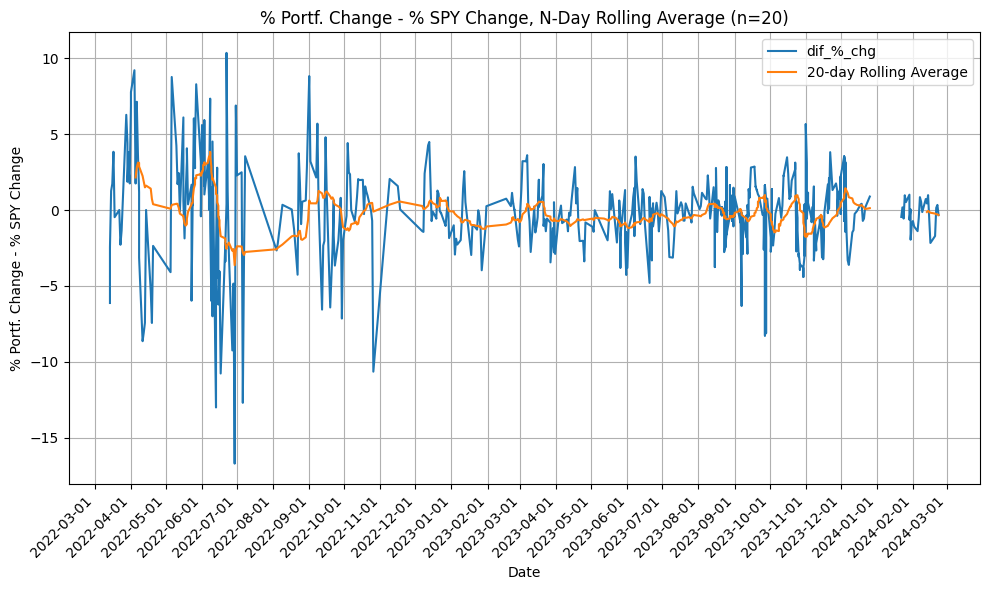

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Load and filter data
df = df_model_perf_with_date_sell.copy()  # Create a copy to avoid modifying the original data

# TODO
# Sort by date
# df = df.sort_values(by="date")
df = df.sort_values(by="date").reset_index(drop=True)
# TODO


# Select data between specified dates (inclusive)
date_start = previous_date_str
date_end = today_str
df = df[(df['date'] >= date_start) & (df['date'] <= date_end)]

# Calculate the rolling average
n_day_window = 20
df["Rolling Average"] = df["dif_%_chg"].rolling(window=n_day_window).mean()

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data and rolling average
plt.plot(df["date"], df["dif_%_chg"], label="dif_%_chg")
plt.plot(df["date"], df["Rolling Average"], label=f"{n_day_window}-day Rolling Average")

# Customize the plot
plt.xlabel("Date")
plt.ylabel("% Portf. Change - % SPY Change")
plt.title(f"% Portf. Change - % SPY Change, N-Day Rolling Average (n={n_day_window})")

# Set major tick locations to monthly intervals
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Format date labels
date_form = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_form)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust spacing for better fit

plt.legend()
plt.grid(True)
plt.show()


In [70]:
print(df.tail(100))

           date      days_lookback    syms_freq                  symbols    date_buy      sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell     sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell   $_SPY_sell  %_SPY_chg  dif_%_chg  win  Rolling Average
1415 2023-11-13      [30, 60, 120]   sym_freq_9          ['FTSM', 'SHV']  2023-11-14        [8.0, 4.0]   906.308441      [2.0]  893.836060  2023-11-17        [8.0, 4.0]    906.782288     0.052283       [2.0]   897.939392   0.459070  -0.406787    0        -0.504434
1416 2023-11-14      [30, 60, 120]   sym_freq_8          ['FTSM', 'NRG']  2023-11-15       [8.0, 10.0]   942.354195      [2.0]  895.728333  2023-11-20       [8.0, 10.0]    940.565804    -0.189779       [2.0]   904.851379   1.018506  -1.208285    0        -0.414854
1417 2023-11-14      [30, 60, 120]   sym_freq_9                  ['SHV']  2023-11-15             [9.0]   979.710823      [2.0]  895.728333  2023-11-20             [9.0]    980.421432     0.072533       [2.